In [1]:
import numpy as np
import torch
from tqdm import tqdm
from time import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
today = '200609'

# Timing benchmark

In this notebook, we would like to time the different algorithms (RC, SRC, and RK) on time series prediction.

For each of them, we record the time for 4 different steps:
- init time: how long it takes to initialize the network (i.e. generate the random matrices)
- forward time: corresponds to the recurrent iterations
- train time: corresponds to the linear regression
- pred time: corresponds to the recursive predictions

We use time series of length 10,000 for training and 2,000 for testing. Recursive prediction is repeated 600 times.

In [2]:
# Generation of Kuramoto-Sivashinsky dataset
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 2000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)

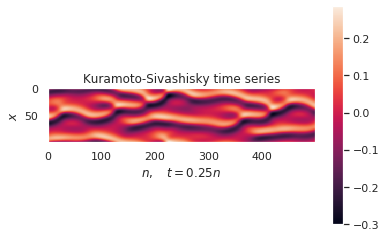

In [3]:
N_plot = 500
u_plot = u[:N_plot,:]

plt.figure()
plt.imshow(u_plot.T)
plt.colorbar()
plt.grid(b=None)
plt.xlabel(r"$n, \quad t={:}n$".format(dt))
plt.ylabel(r"$x$")
plt.title("Kuramoto-Sivashisky time series");

# Reservoir Computing timing benchmark

In [4]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

n_curves = 3
n_res_range = np.logspace(2, 4, num=n_curves, dtype=int)
input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
alpha = 1e-2
leak_rate = 1

n_p = len(n_res_range)
init_time = np.zeros((n_p, 1))
forward_time = np.zeros((n_p, 1))
train_time = np.zeros((n_p, 1))
pred_time = np.zeros((n_p, 1))
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
    bias = bias_scale * torch.randn(n_res).to(device)
    
    start = time()
    torch.cuda.synchronize()
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', leak_rate=leak_rate, bias=bias, random_projection='gaussian')
    torch.cuda.synchronize()
    init_time[i] = time() - start
    start = time()
    torch.cuda.synchronize()
    X = model.forward(u_train_t).to(device)
    X = torch.cat((X, u_train_t*renorm_factor), dim=1)
    torch.cuda.synchronize()
    forward_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    output_w = model.train(X, out_train, alpha=alpha)
    torch.cuda.synchronize()
    train_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    test_len = 2000
    Xtest = model.forward(u_test_t[:test_len]).to(device)

    n_rec = 600
    test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)
    torch.cuda.synchronize()
    pred_time[i] = time() - start

3it [00:55, 18.55s/it]


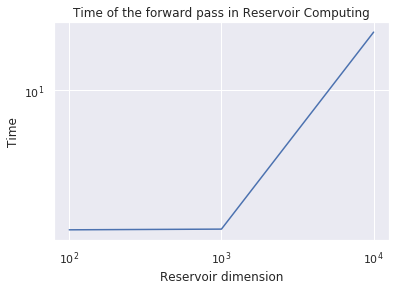

In [5]:
plt.loglog(n_res_range, forward_time)
plt.title('Time of the forward pass in Reservoir Computing')
plt.xlabel('Reservoir dimension')
plt.ylabel('Time');

In [ ]:
times = np.concatenate((init_time, forward_time, train_time, pred_time), axis=1)
np.save('out/' + today + '_time_rc_kslen1e4', times)

# Structured Reservoir Computing

In [9]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

first_pow = 8
last_pow = 14  # 2**20 => ~10^6
n_res_range = np.logspace(first_pow, last_pow, num=last_pow-first_pow+1, base=2., dtype=int) - input_dim
input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
alpha = 1e-2
leak_rate = 1

n_p = len(n_res_range)
init_time = np.zeros((n_p, 1))
forward_time = np.zeros((n_p, 1))
train_time = np.zeros((n_p, 1))
pred_time = np.zeros((n_p, 1))
for i, n_res in tqdm(enumerate(n_res_range)):
    initial_state = torch.randn(n_res).to(device) / np.sqrt(n_res)
    renorm_factor = 1.1 * np.sqrt(input_dim / n_res)
    bias = bias_scale * torch.randn(n_res).to(device)
    
    start = time()
    torch.cuda.synchronize()
    model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, 
                          f='erf', leak_rate=leak_rate, bias=bias, random_projection='structured')
    torch.cuda.synchronize()
    init_time[i] = time() - start
    start = time()
    torch.cuda.synchronize()
    X = model.forward(u_train_t).to(device)
    X = torch.cat((X, u_train_t*renorm_factor), dim=1)
    torch.cuda.synchronize()
    forward_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    output_w = model.train(X, out_train, alpha=alpha)
    torch.cuda.synchronize()
    train_time[i] = time() - start

    start = time()
    torch.cuda.synchronize()
    test_len = 2000
    Xtest = model.forward(u_test_t[:test_len]).to(device)

    n_rec = 600
    test_rec_pred = model.rec_pred(Xtest, output_w, n_rec, input_dim, concat=u_test_t[:test_len]*renorm_factor, renorm_factor=renorm_factor)
    torch.cuda.synchronize()
    pred_time[i] = time() - start

7it [00:36,  5.16s/it]


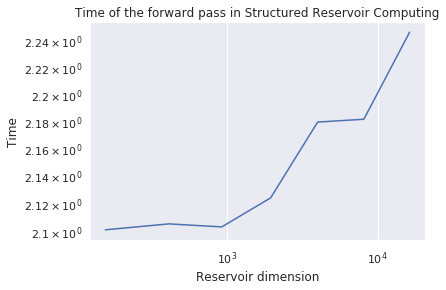

In [10]:
plt.loglog(n_res_range, forward_time)
plt.title('Time of the forward pass in Structured Reservoir Computing')
plt.xlabel('Reservoir dimension')
plt.ylabel('Time');

In [13]:
times = np.concatenate((init_time, forward_time, train_time, pred_time), axis=1)
np.save('out/' + today + '_time_src_kslen1e4', times)

ValueError: zero-dimensional arrays cannot be concatenated

# Recursive kernels

In [11]:
u_train_t = torch.from_numpy(u_train).to(device)
u_test_t = torch.from_numpy(u_test).to(device)
input_len, input_dim = u_train_t.shape

pred_horizon_range = 1
out_train = torch.zeros(input_len, input_dim * pred_horizon_range).to(device)
for pred_horizon in range(1, pred_horizon_range+1):
    out_train[:, (pred_horizon-1)*input_dim:pred_horizon*input_dim] = torch.roll(u_train_t, -pred_horizon, dims=0)

input_scale = 0.4
res_scale = 0.9
bias_scale = 0.4
renorm_factor = 1.1
alpha = 1e-2
n_iter = 50

print("Training forward")
start = time()
torch.cuda.synchronize()
model = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, n_iter=n_iter,
                           bias_scale=bias_scale)
torch.cuda.synchronize()
init_time = time() - start
start = time()
torch.cuda.synchronize()
K = model.forward(u_train_t).to(device)
final_input_gram = u_train_t[n_iter-1:, :] @ u_train_t[n_iter-1:, :].T
K += renorm_factor * final_input_gram
torch.cuda.synchronize()
forward_time = time() - start

print("Training weights")
start = time()
torch.cuda.synchronize()
output_w = model.train(K, out_train[n_iter-1:, :], alpha=alpha)
del out_train
torch.cuda.synchronize()
train_time = time() - start

print("Testing forward")
start = time()
torch.cuda.synchronize()
test_len = 2000
Ktest, diag_res_train, diag_res_test = model.forward_test(u_train_t, u_test_t[:test_len])

print("Testing recursive prediction")
n_rec = 600
test_rec_pred = model.rec_pred_fast(Ktest, u_train_t, u_test_t[:test_len], output_w, n_rec, diag_res_train, diag_res_test, concat=renorm_factor)
torch.cuda.synchronize()
pred_time = time() - start

Training forward
Training weights
Testing forward
Testing recursive prediction


In [14]:
times = np.array([init_time, forward_time, train_time, pred_time])
np.save('out/' + today + '_time_rk_kslen1e4', times)